In [1]:
# import public packages
import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle
import scipy
import mne
import sys

from mne.time_frequency import tfr_morlet
from mne.baseline import rescale
from mne.stats import permutation_cluster_test
from scipy.signal import spectrogram, hann, butter, filtfilt, hilbert
from scipy import signal, interpolate, stats
from scipy.interpolate import make_interp_spline, BSpline
from io import open
from importlib import reload

# import own functions
from utils import find_folders
import dat_preproc
import fix_annot_onsets
import mat2fif
import baseline_correction
import normalization

### Add Directories/ Load Files

In [2]:
reload(find_folders)
onedrive = find_folders.get_onedrive_path()
project_path = find_folders.get_onedrive_path("entrainment")
print(project_path)

C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT


### Select Peaks and Plot Analytic Signal

In [79]:
#Load raw fif data

test_raw = mne.io.read_raw_fif(os.path.join(
    project_path,
        'data',
        'Fifs',
        'test',
        'Sub009_FIF.fif'
    )
)

subID = 'Sub009'
fft_name = str(subID) + '_'
print(fft_name)

Opening raw data file C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT\data\Fifs\test\Sub009_FIF.fif...
    Reading extended channel information
    Range : 0 ... 199186 =      0.000 ...   796.744 secs
Ready.
Sub009_


C:\Users\mathiopv\AppData\Local\Temp\ipykernel_11380\2242991131.py:3: RuntimeWarning: This filename (C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT\data\Fifs\test\Sub009_FIF.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  test_raw = mne.io.read_raw_fif(os.path.join(


In [ ]:
#Load Power Spectra 
%matplotlib qt
ps_zscored = pd.read_csv(os.path.join(
    project_path,
        'data',
        'power_spectra',
        'test',
        'Sub005_FFT_zscoredPS.csv'
))
plt.plot(ps_zscored['StimOff'], label = 'Med On - Stim Off')
plt.plot(ps_zscored['StimOn'], label  = 'Med On - Stim On')
plt.legend(loc='upper right')
plt.xlabel('Frequency [Hz]')
plt.ylabel('LFP Power [zscored]')
plt.xlim(50,90)
plt.ylim(-0.6, 1.3)


In [ ]:
plt.savefig('Sub017_Exemplary_ZscoredPS',dpi = 150)

In [ ]:
reload(dat_preproc)
x = test_raw.get_data() #getting only RSTN channel
x1 = x[0,:]

peakMed = 81
peakStim = 65

dat_ngam = dat_preproc.low_highpass_filter(x1, peakMed-2, peakMed+2) 
dat_subh = dat_preproc.low_highpass_filter(x1, peakStim-2, peakStim+2) 

datall = [dat_ngam, dat_subh] 
labels = ['Peak 81Hz','Peak 65Hz']

In [ ]:
def window_rms(a, window_size):
  a2 = np.power(a,2)
  window = np.ones(window_size)/float(window_size)
  return np.sqrt(np.convolve(a2, window, 'valid'))

In [ ]:
%matplotlib qt
sm_signal_np = np.empty(shape = (2, x1.shape[0] - 499))
sm_signal_np[:] = np.nan

fig, axes = plt.subplots(1, 1, figsize=(12, 5))
wintosmooth = 500

for idx, dat in enumerate(datall):
    hiltr = hilbert(dat)
    amplitude_envelope = np.abs(hiltr)
    zscore_sign = stats.zscore(np.squeeze(amplitude_envelope))

    sm_signal = window_rms(zscore_sign, wintosmooth)
    
    plt.plot(sm_signal, label = labels[idx])
    #plt.plot(np.arange(0,75000), amplitude_envelope, label = labels[idx]) 
    
    #axes[idx].axvline(26250, color = 'b', ls='--', lw=2, label = 'Stim On')
    #axes[idx].axvline(50250, color = 'g', ls='--', lw=2, label = 'Stim Off')
    plt.ylabel('Analytic Signal')
    plt.xlim([0, sm_signal.shape[0]])

    
    sm_signal_np[idx,:] = sm_signal

    #axes[idx].set_xticks(ticks = np.arange(0, 80000, 10000), labels = np.arange(0,320,40))
    plt.xlabel('Time [sec]')

    

plt.suptitle('Smoothing Window: 500 samples')
plt.legend(loc='upper right')

plt.show()


In [ ]:
x2 = x[4, :] 
sm_stim = window_rms(x2, wintosmooth)
sm_stim1 = (sm_stim)

In [ ]:
fig, ax1 = plt.subplots(figsize = (18,6))
#plt.rcParams['font.size'] = 10
ax2 = ax1.twinx()
for idx, dat in enumerate(sm_signal_np):
    ax1.plot(sm_signal_np[idx,:], label = labels[idx], lw = 2)
ax2.plot(sm_stim1, label = 'Stimulation', color = 'grey', ls='--', lw=3, alpha = 0.4)
ax1.legend()
ax1.set_ylabel('Z-scored Smoothed Analytic Signal')
ax2.set_ylabel('Stimulation Amplitude [mA]')
#ax2.set_yticks(np.arange(0.5, 2.5, 0.25))
#ax2.set_yticklabels(np.arange(0.25, 2.25, 0.25))
#ax1.set_xlim(0, sm_signal_np.shape[0])
ax1.set_xticks(np.arange(0, 100000, 20000))
ax1.set_xticklabels(np.arange(0, 400, 80))
ax1.set_xlabel('Time [sec]')
plt.title(str(subID))
plt.show()

In [ ]:
sm_analSignal = np.transpose(np.squeeze(np.array([[sm_signal_np[0]], [sm_signal_np[1]],[sm_stim1]])))
sm_analSignal_df = pd.DataFrame(sm_analSignal,
    columns = ['Spontan','StimOn','StimVec'],
    )
print(sm_analSignal_df)

In [ ]:
fft_fig = os.path.join(project_path, 'figures','FFts','test/')
fft_file = os.path.join(project_path, 'data','anal_signal/')

plt.savefig(str(fft_fig)+str(fft_name)+'sm_analSignal',dpi = 300)
sm_analSignal_df.to_csv(str(fft_file)+str(fft_name)+'sm_analSignal.csv')

### Crop Analytic Signal to Epochs of Interest

In [80]:
sm_anal = pd.read_csv(os.path.join(
    project_path,
        'data',
        'anal_signal',
        'Sub009_sm_analSignal.csv'
))

print(sm_anal)

subID = 'Sub009'
fft_name = str(subID) + '_'
print(fft_name)

        Unnamed: 0   Spontan    StimOn  StimVec
0                0  0.967818  0.851086      0.0
1                1  0.968528  0.848726      0.0
2                2  0.968903  0.846447      0.0
3                3  0.969024  0.844113      0.0
4                4  0.969884  0.841790      0.0
...            ...       ...       ...      ...
198683      198683  1.087056  1.097227      NaN
198684      198684  1.089349  1.099135      NaN
198685      198685  1.092308  1.100998      NaN
198686      198686  1.094630  1.102957      NaN
198687      198687  1.096759  1.105026      NaN

[198688 rows x 4 columns]
Sub009_


In [84]:
#CROP IT

med1 = 0
med2 = 30
stim1 = 647
stim2 = 658

sm_anal1 = sm_anal.iloc[med1*250 : med2*250]
sm_anal2 = sm_anal.iloc[stim1*250 : stim2*250]
sm_toplot = pd.concat([sm_anal1, sm_anal2])
print(sm_toplot)

        Unnamed: 0   Spontan    StimOn   StimVec
0                0  0.967818  0.851086  0.000000
1                1  0.968528  0.848726  0.000000
2                2  0.968903  0.846447  0.000000
3                3  0.969024  0.844113  0.000000
4                4  0.969884  0.841790  0.000000
...            ...       ...       ...       ...
164495      164495  0.976796  1.834470  2.327720
164496      164496  0.976449  1.833477  2.327325
164497      164497  0.975944  1.832420  2.326929
164498      164498  0.975270  1.831285  2.326534
164499      164499  0.974420  1.830059  2.326138

[10250 rows x 4 columns]


In [83]:
sm_anal1.shape[0] + sm_anal2.shape[0]

10250

In [ ]:
#PLOT IT

%matplotlib qt
plt.plot(np.arange(0,sm_toplot.shape[0]),sm_toplot['Spontan'], label = 'Peak 82Hz')
plt.plot(np.arange(0,sm_toplot.shape[0]),sm_toplot['StimOn'], label = 'Peak 72Hz')
plt.axvline(x = 7500, color = 'grey', ls='--', lw=3, alpha = 0.4, label = 'Stim On')
plt.xlabel('Time [samples]')
plt.ylabel('Z-scored Smoothed Analytic Signal')
plt.title(str(subID))
plt.xlim([0, sm_toplot.shape[0]])
plt.legend()
plt.show()

In [ ]:
fft_fig = os.path.join(project_path, 'figures','FFts','test/')
fft_file = os.path.join(project_path, 'data','anal_signal/')

plt.savefig(str(fft_fig)+str(fft_name)+'sm_analSignalCROPPED',dpi = 150)
sm_toplot.to_csv(str(fft_file)+str(fft_name)+'sm_analSignalCROPPED.csv')

### Average Cropped Analytic Signal and Plot

In [33]:
med_anal = pd.read_csv(os.path.join(
    project_path,
    'data',
    'anal_signal',
    'Med_AllAnalCropped.csv'
))

stim_anal = pd.read_csv(os.path.join(
    project_path,
    'data',
    'anal_signal',
    'Stim_AllAnalCropped.csv'
))

print(stim_anal)

         Sub005    Sub006    Sub009    Sub014    Sub017    Sub029
0      0.796159  0.881777  0.851086  0.526401  0.806174  0.769114
1      0.796054  0.879257  0.848726  0.527014  0.804659  0.767466
2      0.796050  0.876840  0.846447  0.527712  0.804158  0.766451
3      0.796008  0.874098  0.844113  0.528500  0.803850  0.765561
4      0.795919  0.871046  0.841790  0.529381  0.803369  0.764568
...         ...       ...       ...       ...       ...       ...
14995  0.452509  1.192893       NaN       NaN  0.756172  1.132045
14996  0.453855  1.192651       NaN       NaN  0.757206  1.133623
14997  0.455213  1.192411       NaN       NaN  0.758185  1.135083
14998  0.456583  1.192173       NaN       NaN  0.759083  1.136428
14999  0.457966  1.191940       NaN       NaN  0.759884  1.137660

[15000 rows x 6 columns]


In [34]:
med_anal_mean = np.nanmean(med_anal,1)
med_anal_sem = stats.sem(med_anal,1, nan_policy='omit')

stim_anal_mean = np.nanmean(stim_anal,1)
stim_anal_sem = stats.sem(stim_anal,1, nan_policy='omit')


In [38]:
7500+2500

10000

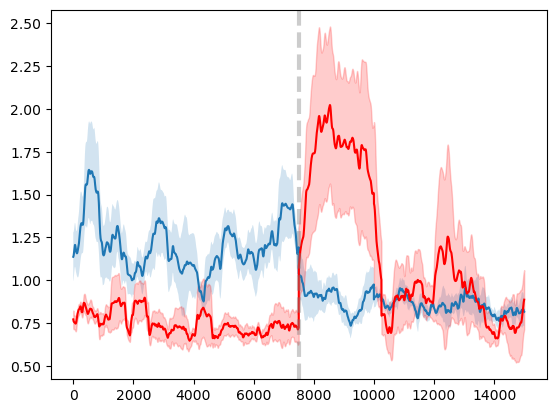

In [35]:
plt.plot(np.arange(0,15000 ), med_anal_mean, label = 'Spontaneous FTG')
plt.fill_between(np.arange(0,15000), med_anal_mean-med_anal_sem, med_anal_mean+med_anal_sem, alpha = 0.2)

plt.plot(np.arange(0,15000 ), stim_anal_mean, color = 'red', label = 'Spontaneous FTG')
plt.fill_between(np.arange(0,15000), stim_anal_mean-stim_anal_sem, stim_anal_mean+stim_anal_sem, color = 'red', alpha = 0.2)


plt.axvline(x = 7500, color = 'grey', ls='--', lw=3, alpha = 0.4, label = 'Stim On')


In [5]:
pval = 0.001  # arbitrary
dfn = 2 - 1  # degrees of freedom numerator
dfd = med_anal.shape[0] - 2  # degrees of freedom denominator
thresh = scipy.stats.f.ppf(1 - pval, dfn=dfn, dfd=dfd)  # F distribution
print(thresh)

10.831836717448908


In [115]:
perm_nd = np.empty([6,med_anal.shape[0]])
perm_nd[:] = np.nan
perm_nd[0,:] = np.transpose(med_anal)

ValueError: could not broadcast input array from shape (6,15000) into shape (15000,)

In [19]:
y = np.expand_dims(med_anal, axis = 2)
y1 = np.expand_dims(stim_anal, axis = 2)


In [24]:
#H0 = np.empty([1000,6])
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([y, y1], n_permutations=1000,
                             threshold=None, n_jobs=None)


Using a threshold of 3.841769
stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 2 clusters


C:\Users\mathiopv\AppData\Local\Temp\ipykernel_21896\2373014700.py:3: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  permutation_cluster_test([y, y1], n_permutations=1000,
C:\Users\mathiopv\AppData\Local\Temp\ipykernel_21896\2373014700.py:3: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  permutation_cluster_test([y, y1], n_permutations=1000,


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [31]:
clusters[0]

(array([0, 1], dtype=int64), array([0, 0], dtype=int64))